![DSL_logo](dsl_logo.png)


# Advanced Text Analysis with Python

Welcome to the Digital Scholarship Lab introduction to Text Analysis with Python class. In this class we'll learn some more advanced text analysis techniques. We will perform a topic modeling exercise using [Latent Dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation). This workshop assumes you've completed our Introduction to Text Analysis [workshop](https://brockdsl.github.io/Text_Analysis_with_Python/) It would be useful to consult our Introduction to Python [Workshop](https://brockdsl.github.io/Intro_to_Python_Workshop/) for a basic introduction to the language. 


We'll use the Zoom's chat feature to interact.

Be sure to enable line numbers by looking for the 'gear' icon and checking the box in the 'Editor' panel.


[https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

# Before we Begin!

1. Please click the 'Copy to Drive' button in the toolbar above
1. Click on the Gear icon next to your picture, Select 'Editor' and make sure 'Show Line Numbers' is selected
1. Share in the chat box a quick hello and where you are in the world right now.

# Libraries, Libraries, Libraries

We need lots of different bits and pieces to build and run our project. Please run the following cell to do that. It might take a bit for it to finish however!

In [1]:
# spacy for lemmatization
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install pyLDAvis


# Gensim
import gensim
import nltk
import spacy
import pyLDAvis
import pyLDAvis.gensim_models
import warnings

import gensim.corpora as corpora
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from pprint import pprint
from random import randint


#Set some parameters
%matplotlib inline
nltk.download('stopwords')
pd.set_option('display.max_colwidth', 999)
pyLDAvis.enable_notebook()
TOPICS_TO_SHOW = 10
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

print("\nDone importing Librarians!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 10.0 MB/s eta 0:00:0000:0100:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


/usr/local/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload



Done importing Librarians!


# The general steps for Topic Modelling

- Remove Stopwords
- Create Bigrams
- Lemmitize the text
- Create Bags of words
- Feed Bags of words into LDA model builder

# Corpus


![winnie_splash](https://raw.githubusercontent.com/BrockDSL/Text_Analysis_with_Python/master/winnie_splash.png)

if you joined us for our first text analysis workshop this will look familiar.

Corpus is a fancy way of saying the text that we will be looking at. Cleaning up a corpus and getting it ready for analysis is a big part of the process, once that is done the rest is easy. For our example we are going to be looking at some entries from the 1900 [diary](https://dr.library.brocku.ca/handle/10464/7282) of Winnie Beam. The next cell will load this corpus into a Pandas dataframe and show us a few entires. 

In [2]:
winnie_corpus = pd.read_csv('https://raw.githubusercontent.com/BrockDSL/Text_Analysis_with_Python/master/winnie_corpus.txt', header = None, delimiter="\t")
winnie_corpus.columns = ["page","date","entry"]
winnie_corpus['date'] = pd.to_datetime(winnie_corpus['date'])
winnie_corpus['entry'] = winnie_corpus.entry.astype(str)

data = winnie_corpus["entry"].tolist()


#preview our top entries
winnie_corpus.head()

,page,date,entry
0,7,1900-01-01,"New Year. First day of 1900 Charlie Merritt died at Grand Forks British Columbia yesterday of typhoid fever. To-day is election day and pap went up about 3 o'clock and did not get back until nearly 10. He brought us some candy chocolate drops. We had a very fat goose for dinner, not a very young one. Had to have good teeth."
1,7,1900-01-02,"Went uptown in afternoon. Was up to Eckardt's but Miss Macfarlane was not there so I did not get what I wanted. Called at office and Nettie came home with me for tea. Mr Carman came over and borrowed my Mildred books. Then Leta came & borrowed my German Grammar as she forgot hers & left it at school before holiday. Papa, mamma, Nettie & I played crokinole. Mamma & I beat. The 2nd Contingent left for Toronto today to go to South Africa. Dr King's som went."
2,8,1900-01-03,"Mrs Trusty was here washing School started to-day, but I was not going this week. Mamma went to the church and then to Mrs Chatfields Took her the church books. The queen Street Baptist church had a service of praise this evening. Mrs Chapman is organist & Mrs Read-Muir sang Mrs George Armstrong has a daughter was born on New Year's day."
3,8,1900-01-04,"Went over to Carman's to have Ella go with me to Dunn's greenhouse. We went about half past three. I brought a primrose Miss Chaplin was in there. Mamma went to Mrs Klotz at home Beatrice helped. Papa & I went to Sunday School entertainment at night. Had a very long programme. There was a dialogue called ""Aunt Ketty's shopping which was good, and a shaving scene. Mr perry gave a tableful of prizes away. Beatrice came home with us. They had a drill of girls & they sang ""Soldiers of the Queen"""
4,9,1900-01-05,"Sweep day. I read ""At the Camerons"" in the ""Harper's Young People"" when mamma was sweeping. We had a beggar in afternoon asking for a few cents as he had a long way to go. Rats! Went over to Lee's in afternoon after eggs. Took a ""Young Ladies Journal"" Mrs Pay lent me. Her kitty has a sore tail. Mrs Malcolmson came after eggs when I was there. She got large sum of 2. Had some candy at night."


# Prepparing the Corpus!

![Block Image of Pipeline]()


With out text loaded up we need to now process it so when we compare different entries it will be as close as possiblies to **apples to apples**. Applying all of these preparations is often called a pipeline. We'll setup our pipeline in the next cell. 

In [21]:
#Parameters
BIGRAM_MIN = 1
BIGRAM_THRESH = 10

ALLOWED_POSTAGS = [
    "ADJ",
    "ADP",
    "ADV",
    "AUX",
    "CONJ"
    "CCONJ",
    "DET",
    "INTJ",
    "NOUN",
    #"PART",
    "PRON",
    #"PROPN",
    "SCONJ",
    "VERB"
]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=ALLOWED_POSTAGS):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

data_words = list(sent_to_words(data))
stop_words = stopwords.words('english')
bigram_mod = gensim.models.phrases.Phraser(gensim.models.Phrases(data_words, min_count=BIGRAM_MIN, threshold=BIGRAM_THRESH))
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

print("Done Loading Pipeline")

Done Loading Pipeline


### Stop Words

There are words in Englisht that just connect ideas and phrases but do not add any meaning to our statements. These are generally called stop words and we filter them out from our corpus.

In [22]:
#print out what our Stopwords are
for word in stop_words:
    print(word)

i
me
my
myself
we
our
ours
ourselves
you
you're
you've
you'll
you'd
your
yours
yourself
yourselves
he
him
his
himself
she
she's
her
hers
herself
it
it's
its
itself
they
them
their
theirs
themselves
what
which
who
whom
this
that
that'll
these
those
am
is
are
was
were
be
been
being
have
has
had
having
do
does
did
doing
a
an
the
and
but
if
or
because
as
until
while
of
at
by
for
with
about
against
between
into
through
during
before
after
above
below
to
from
up
down
in
out
on
off
over
under
again
further
then
once
here
there
when
where
why
how
all
any
both
each
few
more
most
other
some
such
no
nor
not
only
own
same
so
than
too
very
s
t
can
will
just
don
don't
should
should've
now
d
ll
m
o
re
ve
y
ain
aren
aren't
couldn
couldn't
didn
didn't
doesn
doesn't
hadn
hadn't
hasn
hasn't
haven
haven't
isn
isn't
ma
mightn
mightn't
mustn
mustn't
needn
needn't
shan
shan't
shouldn
shouldn't
wasn
wasn't
weren
weren't
won
won't
wouldn
wouldn't


### Tokenize words from sentences

We now turn sentences into lists of words

In [23]:
test_text = ["Wow, this is a sentence with words and stuff.",
             "Here is another.",
             "Finally a third",]
for token in sent_to_words(test_text):
    print(token)

['wow', 'this', 'is', 'sentence', 'with', 'words', 'and', 'stuff']
['here', 'is', 'another']
['finally', 'third']


### Bigrams for Phrases

Very common phrases should be kept as phrases. If the two appear next to each enough times we should treat them as a phrase.

In [24]:
documents = ["Sunday School is where you go on Sunday", 
             "Sunday School happens only once a week",]

sentence_stream = [doc.split(" ") for doc in documents]
bigram = gensim.models.Phrases(sentence_stream, min_count=1, threshold=2)

sent = ["Sunday","School","is","where","you","go","on","Sundays"]

print(bigram[sent])


['Sunday_School', 'is', 'where', 'you', 'go', 'on', 'Sundays']


### Lemmitize

Our last prepatory step is to change all of the words in our sentences to their **root words** and at this stage we'll just keep words that are: **Nouns**, **Adjectives**, **Verbs**, & **Adverbs** 

In [25]:
print(lemmatization([["mice"]]))
print(lemmatization([["fishes"]]))

[['mouse']]
[['fish']]


# Applying the pipeline to Diary Entries

Now that we have all of our functions defined we can apply the pipeline to the documents in our corpus. Running the next cell will complete this step. 

In [26]:
# remove stop Words
data_words_nostops = remove_stopwords(data_words)

# form bigrams & trigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# lemmatize
data_lemmatized = lemmatization(data_words_bigrams)

print("Done Prepping the Text!")

Done Prepping the Text!


# How a Random Entry looks

We can now pick individual entries in the corpus and see what they look like when they are processed. Run the cell below a few times and if you find something interesting please share what **random_entry** it was in the chat box. 

In [28]:

random_entry = randint(0,len(data))

print("Random Entry Number: ",random_entry)

print("\n")
print("Original Entry:")
print(data[random_entry])

print("\n")
print("Prepared Text:")

print(data_lemmatized[random_entry])



Random Entry Number:  290


Original Entry:
Took my music lesson. Have VI Jadassohn. Mr read wanted to know whether I sang as it would be benefical to go to the oratorio rehersal he is going to have at Demill. Have to get three pieces, but I think I have one so I came home then went back to Eckhardt's. Got "Valse Chromatique by Leschetizky & Passepied from Le Roi s'amuse by Delibes. Mrs J. Overholt came in to see us and Mr Overholt came after her. Allie brought us some pears. Had to go to Myers so I went to see Leta. I saw her this morning & she wanted me to come.


Prepared Text:
['take', 'want', 'sing', 'would', 'benefical', 'go', 'oratorio', 'rehersal', 'go', 'demill', 'get', 'three_piece', 'think', 'came_home', 'go', 'back', 'eckhardt_got', 'valse_chromatique', 'leschetizky', 'passepie', 'amuse', 'delibe', 'mrs_overholt', 'come', 'see', 'we', 'come', 'pear', 'go', 'myer', 'go', 'see', 'see', 'morning', 'want', 'come']


## Dictionary and corpus etc

With the texts prepped we need to create the 'bag of words', and the dictionary look-up for it

In [29]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency, ie. bag of words
corpus = [id2word.doc2bow(text) for text in texts]

# Building the LDA Model

We'll start with creating a model that only generates two different topics

In [32]:
#Generate Model and get basic dynamics of it
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

print("Done Building Inital Model")

vis = pyLDAvis.gensim_models.prepare(lda_model,corpus,id2word)
vis

Done Building Inital Model


/usr/local/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.065497  0.0       1        1  50.612239
1     -0.065497  0.0       2        1  49.387761, topic_info=               Term        Freq       Total Category  logprob  loglift
46           church   86.000000   86.000000  Default  30.0000  30.0000
78    sunday_school   44.000000   44.000000  Default  29.0000  29.0000
117          uptown   28.000000   28.000000  Default  28.0000  28.0000
37             papa  139.000000  139.000000  Default  27.0000  27.0000
53             take  108.000000  108.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
63             give   20.356440   43.583525   Topic2  -5.3284  -0.0558
1048          drive   21.571256   51.467509   Topic2  -5.2704  -0.1641
241         picture   16.715600   31.509194   Topic2  -5.5254   0.0715
42             want   18.022297   39.037045   Topic2  -5.4502  -0.0674
200            send   13.695573   32.573773   Topic2  -5.7247  -0.1610

[157 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
21        1  0.357283    afternoon
21        2  0.643109    afternoon
157       1  0.940417       around
1223      1  0.079499  aunt_lillie
1223      2  0.953992  aunt_lillie
...     ...       ...          ...
43        1  0.273985  went_uptown
43        2  0.739760  went_uptown
1119      2  0.850515         wood
19        1  0.267175    yesterday
19        2  0.734730    yesterday

[181 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

## Coherence Plot

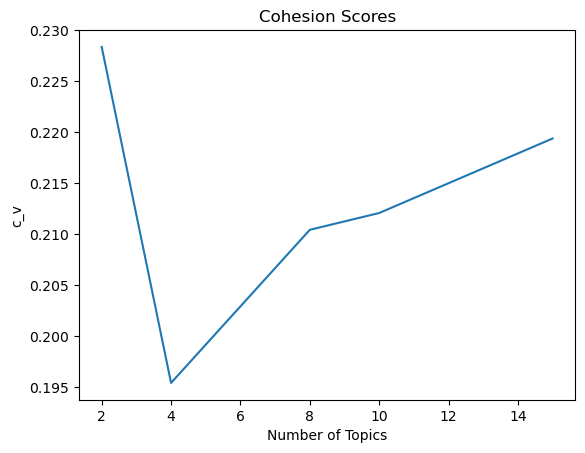

,num_topics,c_v
0,2,0.228358
1,4,0.195417
2,8,0.210428
3,10,0.212074
4,15,0.219380


In [33]:
TOPIC_CHOICES = [2,4,8,10,15]
COHERENCE_METHOD = 'c_v'

c_Scores = []
for t_number in TOPIC_CHOICES:
    lda_model_test = gensim.models.ldamodel.LdaModel(corpus=corpus,num_topics=t_number,id2word=id2word)
    cs = CoherenceModel(model = lda_model_test, \
                               texts = data_lemmatized, \
                               dictionary = id2word, \
                               coherence = COHERENCE_METHOD
                     )
    c_Scores.append(cs.get_coherence())
    
    
plt.plot(TOPIC_CHOICES, c_Scores)
plt.title("Cohesion Scores")
plt.ylabel(COHERENCE_METHOD)
plt.xlabel("Number of Topics")
plt.show()
    
cScore_df = pd.DataFrame(list(zip(TOPIC_CHOICES,c_Scores)))
cScore_df.columns = ["num_topics",COHERENCE_METHOD]
cScore_df

# Final Model?

Now that we have some guidance on the number of topics to use, let's build and visualize our model again

In [34]:
TOPICS = 4

In [35]:
#Generate Model and get basic dynamics of it
lda_model_2 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=TOPICS, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

print("Done Building Inital Model")

vis2 = pyLDAvis.gensim_models.prepare(lda_model_2,corpus,id2word)
vis2

Done Building Inital Model


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.214403 -0.041877       1        1  62.486835
1     -0.011378  0.155742       2        1  14.701054
0     -0.086253 -0.083413       3        1  14.536467
3     -0.116772 -0.030453       4        1   8.275644, topic_info=        Term        Freq       Total Category  logprob  loglift
10        go  476.000000  476.000000  Default  30.0000  30.0000
53      take  112.000000  112.000000  Default  29.0000  29.0000
46    church  100.000000  100.000000  Default  28.0000  28.0000
1048   drive   52.000000   52.000000  Default  27.0000  27.0000
29       get  250.000000  250.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
355    catch    2.631046   12.557573   Topic4  -5.5880   0.9289
442      tie    2.394336    7.857141   Topic4  -5.6823   1.3035
7      first    2.713246   32.219063   Topic4  -5.5572   0.0174
26      come    2.870727  142.341295   Topic4  -5.5008  -1.4118
472     meet    2.527854   22.251330   Topic4  -5.6280   0.3168

[246 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
118       4  0.780646      address
2020      4  0.494021  affirmative
21        1  0.918643    afternoon
21        2  0.056408    afternoon
21        3  0.008058    afternoon
...     ...       ...          ...
336       2  0.972431        would
480       2  0.942273        write
801       2  0.955713        wrong
19        1  0.945473    yesterday
19        3  0.059092    yesterday

[289 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

# What makes a topic?

Let's look at the top words associated with each topic to see if we can get a sense of what each one might be 'about'

In [78]:
for t in range(0,TOPICS):
    print("\nTopic Number: ",t+1)
    print("\n")
    topic_phrase = lda_model_2.print_topic(t,topn=TOPICS_TO_SHOW)
    for tp in topic_phrase.split("+ "):
        print(tp.replace("*"," -> "))


Topic Number:  1


0.022 -> "get" 
0.014 -> "day" 
0.013 -> "drive" 
0.011 -> "dinner" 
0.009 -> "fix" 
0.008 -> "we" 
0.007 -> "bad" 
0.006 -> "cold" 
0.006 -> "go" 
0.006 -> "buy"

Topic Number:  2


0.025 -> "get" 
0.020 -> "take" 
0.009 -> "come" 
0.009 -> "play" 
0.008 -> "make" 
0.007 -> "day" 
0.007 -> "night" 
0.007 -> "first" 
0.007 -> "buy" 
0.007 -> "deer"

Topic Number:  3


0.088 -> "go" 
0.035 -> "get" 
0.028 -> "papa" 
0.024 -> "come" 
0.023 -> "night" 
0.021 -> "afternoon" 
0.019 -> "church" 
0.018 -> "morning" 
0.016 -> "take" 
0.015 -> "see"

Topic Number:  4


0.011 -> "clean" 
0.011 -> "see" 
0.008 -> "fish" 
0.008 -> "aunt_lillie" 
0.008 -> "get" 
0.007 -> "horse" 
0.007 -> "turn" 
0.006 -> "drive" 
0.005 -> "ring" 
0.005 -> "burn"


# Which Entries Go to Which Topics?

Now that we have a stable description of topics in the text. Let's see which entries are associated with each topic

In [83]:
top_cats = []
top_prop = []

for i in range(0,len(corpus)):
  #print(f_lookup[i], "->",sorted(lda_model.get_document_topics(corpus[i]),key = lambda tup: tup[1],reverse=True)[0])
  top_cats.append(sorted(lda_model_2.get_document_topics(corpus[i]),key = lambda tup: tup[1],reverse=True)[0][0] + 1)
  top_prop.append(sorted(lda_model_2.get_document_topics(corpus[i]),key = lambda tup: tup[1],reverse=True)[0][1])


winnie_corpus['topic'] = top_cats
winnie_corpus['prob_for_topic'] = top_prop

winnie_corpus.groupby(['topic'])[['entry']].count()

,entry
topic,
1,40
2,47
3,255
4,21


## Closer look at a topic?

Change the value of **topic_to_view** to a number in the list above to see the top 15 words identified with that topic and 5 random entries that have that topic as the primary identified topic of the entry

In [88]:
topic_to_view = 3
confidence_threshold = .9

topic_phrase = lda_model_2.print_topic(topic_to_view-1,topn=TOPICS_TO_SHOW)
for tp in topic_phrase.split("+ "):
    print(tp.replace("*"," -> "))

winnie_corpus[(winnie_corpus['topic'] == topic_to_view) & (winnie_corpus['prob_for_topic'] >= confidence_threshold)].sample(5)

0.088 -> "go" 
0.035 -> "get" 
0.028 -> "papa" 
0.024 -> "come" 
0.023 -> "night" 
0.021 -> "afternoon" 
0.019 -> "church" 
0.018 -> "morning" 
0.016 -> "take" 
0.015 -> "see"


,page,date,entry,topic,prob_for_topic
84,49,1900-03-26,"Made marmalade. Papa and Sydney Bunting went to the Falls. Mamma and I went to the club at night It was at Armstrong's. There were only six of the club there and Mr & Mrs J. Jeffrey Dr Buchanan, Will Burleigh, Miss Harris, & Mr Creelman Mrs Jeffrey's brother. Saw the baby. Dr Buchanan came home with mamma & I",3,0.969780
2,8,1900-01-03,"Mrs Trusty was here washing School started to-day, but I was not going this week. Mamma went to the church and then to Mrs Chatfields Took her the church books. The queen Street Baptist church had a service of praise this evening. Mrs Chapman is organist & Mrs Read-Muir sang Mrs George Armstrong has a daughter was born on New Year's day.",3,0.976428
210,113,1900-08-01,"This afternoon I dressed & went to Mrs Pay to see if she would go for a drive. Stella is there. She & Beatrice rode to Niagara this afternoon. Mamma & Mrs Pay went for a drive. Papa went uptown at night to see Dr Kilmer, Beatrice gave Mrs Pay 146 stamps & Mrs Ward 125 as she could not sell them. Papa bought some apricots to-day.",3,0.915114
88,51,1900-03-30,"Carrie is seriously ill in Santa Barbara. Mr Gould started there on Wednesday. I sent for 26 picutes from Brown & Co. this morning. Went uptown when mamma was sweeping to the Post and Library. Got The Pursuit of the House Boat, by John K. Bangs. Laura brought the buttermilk. Mr Coy wanted papa to go to the Opera House to-night. The play is ""Zaza"".",3,0.978770
263,139,1900-09-23,Went to church. Sermon I Sam. XVIII. 5 verse. Grandpa was at the Baptist Church. Papa and Mr Marquis were out for a walk. We are going to have a missionary Sunday in the Sunday School. Had recitations a duett & missionary hymns. Mr Owen from England staying at Mr H. O'Loughlin's spoke to us. He is to preach to-night read the lessons in morning. Miss Elliots'cousin sang this morning. She had a nice voice Papa & grandpa went to church at night. They were to baptize some people.,3,0.984757


## Bad Matches?

But that about entries that have a bad match to a topic?

In [99]:
bad_threshold = 0.5
winnie_corpus[(winnie_corpus['topic'] == topic_to_view) & (winnie_corpus['prob_for_topic'] <= bad_threshold)].sample(5)

,page,date,entry,topic,prob_for_topic
162,89,1900-06-14,Ella came over in morning and mamma showed her how to cut a waist by new pattern. Our white roses are out. At noon there was two circles around the sun and inside of the circles was a dark space. Maggie brought Pheobie's waist home after so long a time. Frank Overholt was here for tea. Had to go over to Lee's after butter. Band Concert.,3,0.498867
126,71,1900-05-09,"The little wood stove smoked and blacked the spare bedroom ceiling. Mrs Trusty is here, washed & ironed. Gave her my black & green wool jacket. Went over to Meyer's after gingersnaps. In the paper to-night it gave the programme in the church. Very cold.",3,0.472145
18,16,1900-01-19,Was at school in the morning Sat with Leta. Papa came home from Hamilton last night. Practiced in afternoon. Mamma made a very pretty cushion for parlor. Tapestry front and brown back. Papa brought us some candy at night. He bought three tickets for the Redpath Concert Co. that is to be here on Tuesday. Mr Read & Mr Macgregor are bringing them here. Wrote a letter to Aunt Allie,3,0.471991
275,145,1900-10-05,I thought I would rather go to Decew Falls hunting mushrooms than go to the fair so mamma & I went. We got quite a few. It was fun. Coming home we saw some of the prize cattle & horses. Coming from the fair. Saw some red pigs. Eva came over to show me her cards but I was not home. Papa had to go to lodge for a supper and great doings they are to have to-night.,3,0.495412
283,149,1900-10-13,"Took my music IV. of Jadassohn's OP 26. Eva came over and she is going to the Falls. Papa and mamma started right after dinner for the twenty. I washed the dishes and ironed some small things. Mrs Trusty did our washing to-day Then Phoebe and I went uptown. She got a skirt and took Paderewski to have him framed. Eva bought me a Union Jack Hatpin from Falls. Mamma found some lovely apples in the marsh. I made some candy with chocolate in ""Fudge"".",3,0.469983


In [97]:
winnie_corpus[['prob_for_topic']].describe()

,prob_for_topic
count,363.000000
mean,0.713846
std,0.187251
min,0.287255
25%,0.550358
50%,0.655693
75%,0.918415
max,0.990680
